# Using Python and NeuronUnit with two simple models

<center>Fitzhugh and Nagumo, 1969</center>
\begin{matrix} 
\frac{dV}{dt} & = &  \frac{V^3}{3} - W + I  \\
\frac{dU}{dt} & = & \phi(V + a - bU) 
\end{matrix}
<br><br>
<center>Izhikevich, 2007</center>
\begin{matrix} 
\frac{dV}{dt} & = & 0.04V^2 +5V +140 - U + I  \\
\frac{dU}{dt} & = & a(bV - U) \\
\end{matrix}
<center>if $v>30$, set $v=c$ and $u=u+1$

Install (this) copy of NeuronUnit.  May take a few minutes. You can skip if NeuronUnit is already installed in your account.

In [1]:
!pip install -q --user -e ../../
import sys
sys.path.append('../../')

Import all of the basic numerical libraries and set up the plotting environment

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from pathlib import Path
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Now get model files from GitHub (you only need to do this once):

In [3]:
if not Path('Fitzhugh-Nagumo').exists():
    !git clone -q http://github.com/OpenSourceBrain/Fitzhugh-Nagumo

In [4]:
if not Path('IzhikevichModel').exists():
    !git clone -q http://github.com/OpenSourceBrain/IzhikevichModel

Import a model class from NeuronUnit that can work with NeuroML model files.<br>
This will work on JupyterHub, but if you have any problems, try: `!pip install --user git+http://github.com/scidash/neuronunit@dev` in an empty cell.

In [5]:
from neuronunit.models import LEMSModel
# Ignore 'FutureWarning' that may show below; that is an upstream package

/opt/conda/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


Wrap the relevant model files in NeuronUnit classes. I know these are the correct files because all OpenSourceBrain projects have a similar structure: a file describing the model, a file describing a netork of neurons from that model, and a file describing a simulation experiment (and sometimes others). Here I am wrapping the file that describes a simulation experiment because it is easier to "just run it".

In [6]:
izh_model = LEMSModel('IzhikevichModel/NeuroML2/LEMS_2007One.xml')

In [7]:
fhn_model = LEMSModel('Fitzhugh-Nagumo/NeuroML2/LEMS_FitzHughNagumo.xml')

Now run (i.e. simulate, i.e. numerically integrate the differential equations with respect to time) each model

In [8]:
izh_model.run()

In [9]:
fhn_model.run()

Extract the simulated results from each model. I know how to extract these results because I opened the LEMS files (.xml) above and saw that the pointed to specific named cells, populations, and variables.  For example, LEMS_FitzHughNagumo.xml includes (uses) FN.net.nml, which is the underlying model being simulated.  And that file contains `<population id="fn1pop" component="FN" size="1"/>`, which is a population of 1 Fitzhugh Nagumo cell.  `fn1pop` refers to that populaion, and `fn1pop[0]` to its first an only cell.  The `/V` on the end, below, means the voltage state variable.  The other state variable is referred to as `W` but I am going to reassign it to a Python variable called `u` for consistency across models.

In [10]:
# For each model, create a lookup for the state variables `v` and `u`,
# whose values are the corresponding recorded entities in the NeuroML file.
fhn_lookup = {'t': 't', 'v': 'fn1pop[0]/V', 'u': 'fn1pop[0]/W'}
izh_lookup = {'t': 't', 'v': 'RS_pop/0/RS/v', 'u': 'RS_pop/0/RS/u'}
# Note: I have no idea why the first cell is accessed with [0] for one model but /0 for the other!

I've created a function to make it easier to extract the simulation results

In [11]:
def get_results(model, lookup, n_time_steps=np.inf):
    """Given a model, a lookup dictionary, and a number of time steps,
    return the state variables (and time)"""
    return [np.array(model.results[lookup[x]])[:n_time_steps] for x in lookup]

And another function for plotting them

In [12]:
def plot_results(t, v, u, name, offset=3):
    """Plot V and U vs time and against each other
    Offset U by `offset` with each timestep for visualization purposes"""
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    ax[0, 0].plot(t, v)
    ax[0, 0].set_xlabel('Time (s)')
    ax[0, 0].set_ylabel('V')
    ax[1, 0].plot(t, u, 'red')
    ax[1, 0].set_xlabel('Time (s)')
    ax[1, 0].set_ylabel('U')
    ax[0, 1].scatter(v, u+t*offset, color=cm.jet(np.array(t)/max(t)), alpha=0.1)
    ax[0, 1].set_xlabel('V')
    ax[0, 1].set_ylabel('U')
    ax[1, 1].axis('off') # Unused
    plt.suptitle(name)

Now let's extract the FitzHugh-Nagumo results...

In [13]:
t, v, u = get_results(fhn_model, fhn_lookup, n_time_steps=10000)

And plot them...

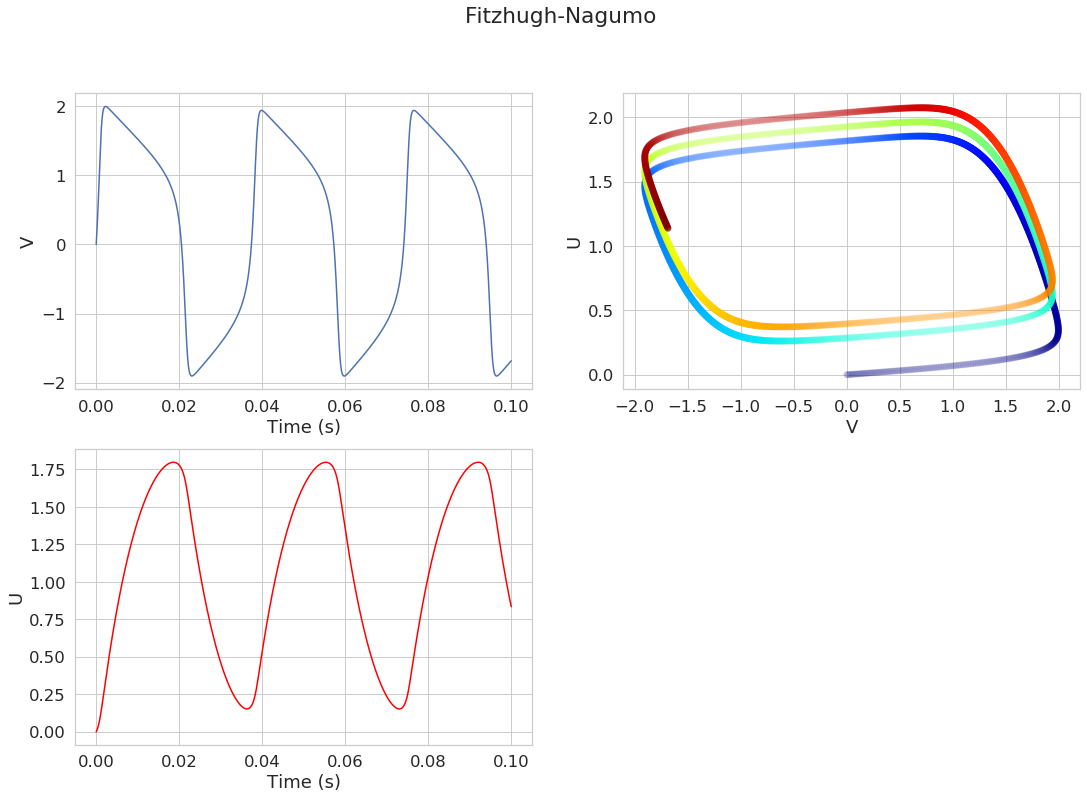

In [14]:
plot_results(t, v, u, 'Fitzhugh-Nagumo')

We can do the same for the Izhikevich model

In [15]:
t, v, u = get_results(izh_model, izh_lookup, n_time_steps=100000)

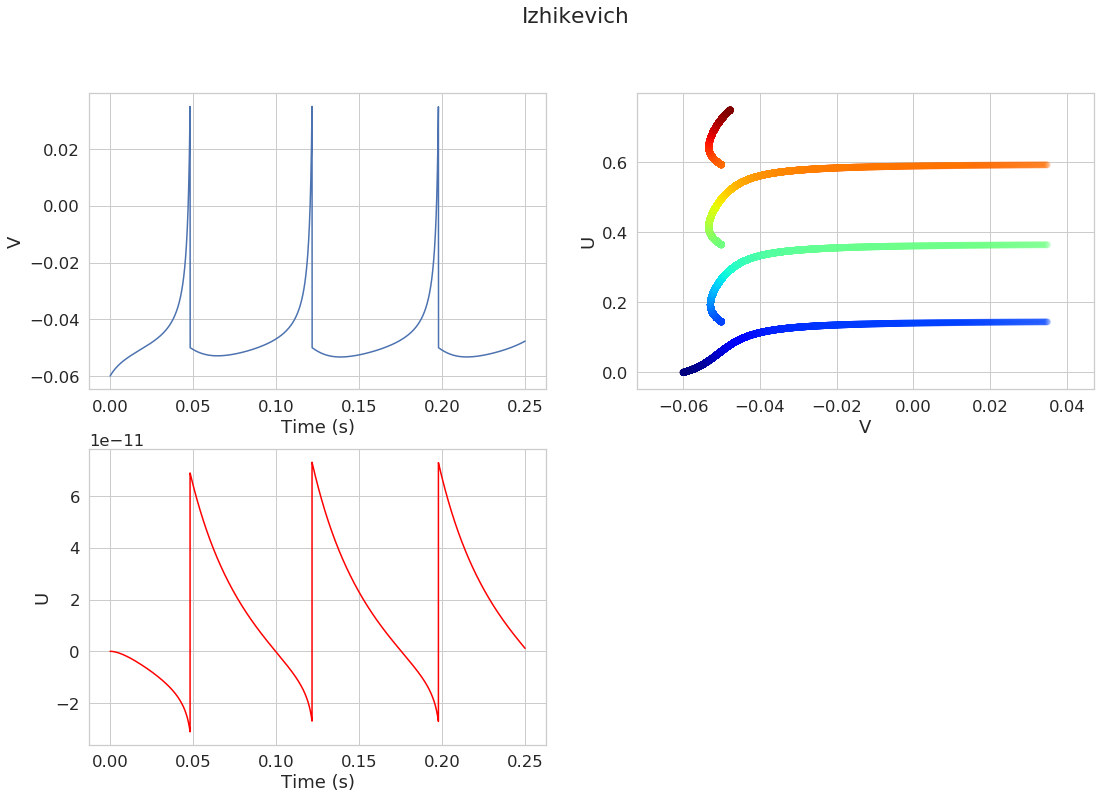

In [16]:
plot_results(t, v, u, 'Izhikevich')

The simulations above are not only for particular values of the model parameters (all the things not called `U`, `V`, or `I` in the equations at the top) but also for particular simulation experiments (particular time-varying values of `I`). You can go into the model directories you checked out from GitHub and edit the files to change these values, which will give different simulation results.  Editing these files is a very tedious way to change model parameters, and not the way we would normally do it.  Next time we will explore how to change these values programatically.

<hr>

BONUS:
You can explore the phase diagram for each model by asking what its gradient is at different points in state space.  In the plots below, we visualize that gradient as a "wind" with arrows.  Any point in state space (any value of V and U) will follow that wind.  The interesting cases are oscillations, when that wind blows in a loop.

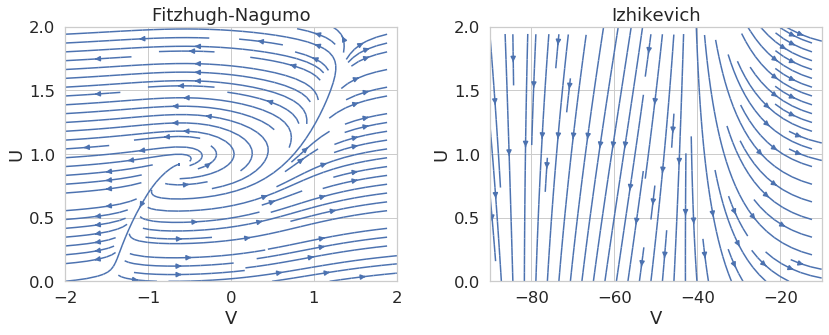

In [17]:
def fhn_derivatives(states, phi=0.08, a=0.7, b=0.8, I=1):
    V, U = states
    vprime = V**3/3 - U + I
    uprime = phi * (V + a - b*U)
    return vprime, uprime

def izh_derivatives(states, a=0.02, b=0.2, c=-65, d=6, I=1):
    V, U = states
    vprime = 0.04*V**2 + 5*V + 140 - U + I
    uprime = a*(b*V - U)
    # Parameters `c` and `d` don't enter the picture
    # until after a spike; we can skip them here
    return vprime, uprime

def stream(name, derivatives, params, vlim, ulim, ax=None):
    vrange = np.linspace(*vlim, 200)
    urange = np.linspace(*ulim, 200)
    v, u = np.meshgrid(vrange, urange)
    vprime, uprime = derivatives([v, u], **params)
    if ax is None:
        ax = plt.gca()
    ax.streamplot(v, u, vprime, uprime)
    ax.set_xlabel('V')
    ax.set_ylabel('U')
    ax.set_title(name)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
stream('Fitzhugh-Nagumo', fhn_derivatives, {'phi': 0.08, 'a': 0.7, 'b': 0.08, 'I': 1}, [-2, 2], [0, 2], ax=ax[0])
stream('Izhikevich', izh_derivatives, {'a': 0.08, 'b': 0.7, 'c': 0.08, 'd': 1}, [-90, -10], [0, 2], ax=ax[1])
plt.tight_layout()